In [37]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
from matplotlib import pyplot as plt
import cv2
import json
from pathlib import Path
import numpy as np
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sn
import pandas as pd
from collections import OrderedDict
from ensemble_boxes import *
import torch
from torchvision import models
from torchvision.transforms import functional as F
import torch.nn as nn
from typing import List


In [2]:
!pwd

/mmdetection/demo


In [ ]:
# carpart_config = '../checkpoints/12_10/carpart/swa_carpart.py' '/mnt/ssd1/hang/CBNetV2/checkpoints/carpart/swa_carpart.pth'
# carpart_checkpoint = '../checkpoints/12_10/carpart/swa_carpart.pth'
# carpart_model = init_detector(carpart_config, carpart_checkpoint, device='cuda:2')

In [39]:
carpart_config = '../checkpoints/carpart/swa_carpart.py'
carpart_checkpoint = '../checkpoints/carpart/swa_carpart.pth'
carpart_model = init_detector(carpart_config, carpart_checkpoint, device='cuda:2')

load checkpoint from local path: ../checkpoints/carpart/swa_carpart.pth


In [ ]:
scratch_config = '../checkpoints/12_10/scratch/swa_scratch_pseudo.py'
scratch_checkpoint = '../checkpoints/12_10/scratch/swa_scratch_12_10.pth'
scratch_model = init_detector(scratch_config, scratch_checkpoint, device='cuda:2')

In [ ]:
crack_config = '../checkpoints/combine_crack_phase_1/combine_crack.py'
crack_checkpoint = '../checkpoints/combine_crack_phase_1/epoch_28.pth'
crack_model = init_detector(crack_config, crack_checkpoint, device='cuda:0')

In [ ]:
glass_broken_config = '../checkpoints/windshield/windshield.py'
glass_broken_checkpoint = '../checkpoints/windshield/swa_model_11.pth'
glass_broken_model = init_detector(glass_broken_config, glass_broken_checkpoint, device='cuda:0')

In [ ]:
#data = Path('/mmdetection/data/cracked_windshield_flickr')
#files = [str(i) for i in data.iterdir() if i.is_file()]
#print(files)
path = Path('/mmdetection/data/windshield/glass_broken')
data = json.load(open(path/'annotations'/'test.json'))
total = json.load(open(path/'annotations'/'total.json'))
print(len(total['annotations']))

In [40]:
carpart_labels = carpart_model.CLASSES

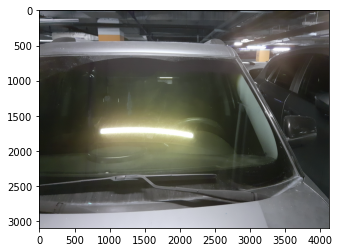

In [41]:
f = '../data/windshield/total_real_data/20211102_201850.jpg'
demo_image = cv2.imread(f)
plt.imshow(demo_image)

In [42]:
def single_model_inference(model,image,confident_score):
    result = inference_detector(model,image.copy())
    out_image,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model,image.copy(),result,score_thr=confident_score)
    
    return pred_boxes,pred_segms,pred_labels,pred_scores,out_image

In [43]:
def check_windshield(segms,labels):
    ws = [(s,l) for idx,(s,l) in enumerate(zip(segms,labels)) if carpart_labels[l] == 'fwi_windshield']
    segms_out = [i[0] for i in ws]
    labels_out = [i[1] for i in ws]
    
    return segms_out,labels_out

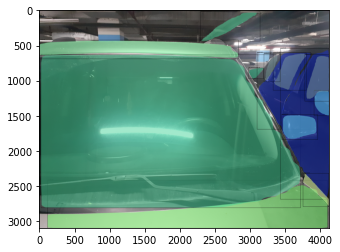

In [44]:
predicted_result = single_model_inference(carpart_model, demo_image, 0.7)
plt.imshow(predicted_result[4])
# print(predicted_image[1]) #pred_segms
# print('-----')
# print(predicted_image[2]) #pred_labels
# windshield_segms, windshield_labels = check_windshield(*predicted_image[1:3])
# plt.imshow(windshield_segms[0])


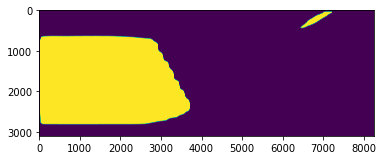

In [45]:
windshield_segms, windshield_labels = check_windshield(*predicted_result[1:3])
plt.imshow(np.hstack([windshield_segms[0], windshield_segms[1]]))

In [46]:
np.random.seed(42)
mask_colors = [
    np.random.randint(0, 256, (1, 3), dtype=np.uint8)
    for _ in range((len(carpart_labels)))
]

def plot_windshield(image,segms,labels):
    for idx,s in enumerate(segms):
        color = mask_colors[labels[idx]]
        color = color.tolist()
        #score = round(scores[idx],2)
        #print(color)
        #print(s)
        
        contours, _ = cv2.findContours(np.array(s).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        #c = []
        if len(contours) == 0:
            continue
        print(len(contours))    
        c = max(contours,key=cv2.contourArea)
        print(c.shape)
        
        #find the centroid's coordinate of the countour
        M = cv2.moments(c)
        if M["m00"] != 0:
            cy = int(M["m01"] / M["m00"])
        else:
            cy = c[0][0][1]
            
        cx = [idi for idi,i in enumerate(s[cy]) if i][0]        
        
        image = cv2.drawContours(image,contours,0,list(color[0]),30)
        #image = cv2.putText(image,carpart_labels[labels[idx]],(cx,cy),cv2.FONT_HERSHEY_SIMPLEX,1,list(color[0]),2,cv2.LINE_AA)
    
    return image

1
(1724, 1, 2)
1
(945, 1, 2)
1
(213, 1, 2)


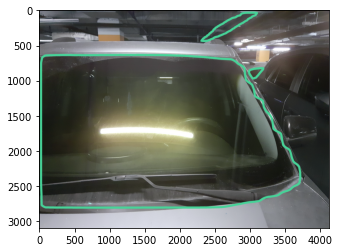

In [47]:
windshield_contour = plot_windshield(demo_image, windshield_segms, windshield_labels)
plt.imshow(windshield_contour)

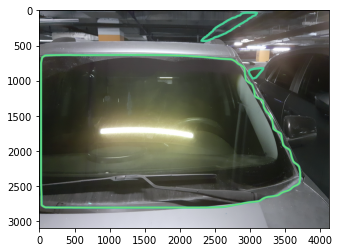

In [48]:
contours= cv2.findContours(np.array(windshield_segms[0]).astype(np.uint8), cv2.cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img = cv2.drawContours(demo_image.copy(),contours[0],0,(255,255,0),2)
plt.imshow(img)

In [49]:
p=contours[0]
p=np.array(p)
contourss = (p.reshape(-1,2)).T
l=np.array(contours[0])
l=np.squeeze(l)
l[0]

array([1137,  637], dtype=int32)

In [50]:
from scipy.spatial import distance
def dist(point1,point2,point3):
  len=distance.euclidean(point1,point3)
  len+=distance.euclidean(point2,point3)
  return len
#


In [51]:
def func_that_returns_the_optimal_point(point1,point2,contours):
  distance={}
  for i in range(len(contours[0])):
    distance[(contours[0][i],contours[1][i])]=dist(point1,point2,(contours[0][i],contours[1][i]))
  distance=dict(sorted(distance.items(), key=lambda item: item[1]))
  lis=list(distance.keys())[0]
  return lis

# #new optimal function below based on shifting the centre of mass of the contours
# def func_that_returns_the_optimal_point(point1,point2,contourss,cX,cY,shape):
#   distance={}
#   contourss_n=contourss.copy()
#   change_x=shape[1]/2-cX
#   change_y=shape[0]/2-cY
#   for i in range(len(contours[0])):
#     contourss_n[0][i]+=change_x
#     contourss_n[1][i]+=change_y
#     distance[(contourss_n[0][i],contourss_n[1][i])]=dist(point1,point2,(contourss_n[0][i],contourss_n[1][i]))
#   distance=dict(sorted(distance.items(), key=lambda item: item[1]))
#   lis=list(distance.keys())[0]
#   lis=list(lis)
#   lis[0]=int(lis[0]-change_x)
#   lis[1]=int(lis[0]-change_y)
  

#   return tuple(lis)

In [52]:
#find the center of contour 
import imutils
cnts = imutils.grab_contours(contours)
cnts=np.array(cnts)
cnts=np.squeeze(cnts)
M=cv2.moments(cnts)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

In [16]:
cY

1510

In [53]:
func_that_returns_the_optimal_point((0,cY),(0,cY),contourss)[1]

2465

In [18]:
cY

1510

In [54]:
# def check_if_front(contourss):
#   dic={}
#   for i in contourss:
#     i=tuple(i)
#     if i[1] in dic:
#      dic[i[1]]+=1
#     else: dic[i[1]]=1
#   dic=dict(sorted(dic.items(), key=lambda item: item[1]))
#   upper=list(dic.keys())[0]
#   lower=list(dic.keys())[-1]
  
#   if dic[upper]>1 and dic[lower]>1:
#     return 1
#   return 0

def check_if_front(contourss,cX,cY,shape):
  #assume that it is front
  #calculate the points accordingly
  #check slope of bottom line, if not zero or close to zero, then not front view
  top_left=func_that_returns_the_optimal_point((0,0),(shape[1]/4,0),contourss)
  top_right=func_that_returns_the_optimal_point((shape[1],0),(3*shape[1]/4,0),contourss)
  bottom_left=func_that_returns_the_optimal_point((0,shape[0]),(0,shape[0]),contourss)
  bottom_right=func_that_returns_the_optimal_point((shape[1],shape[0]),(shape[1],shape[0]),contourss)
  slope=(bottom_right[1]-bottom_left[1])/(bottom_right[0]-bottom_left[0])
  if abs(slope)<0.03:
    return 1
  return 0
  
# def check_if_right(contourss,cX):
#   dic={}
#   for i in range(len(contourss[0])):
#     dic[(contourss[0][i],contourss[1][i])]=contourss[1][i]

#   dic=dict(sorted(dic.items(), key=lambda item: item[1]))
#   if list(dic.keys())[0][0] <cX:
#     return 1
#   return 0

def check_if_right(contourss,cX,cY,shape):
  contourss_n=contourss.copy()
  change_x=shape[1]/2-cX
  change_y=shape[0]/2-cY
  dic={}
  for i in range(len(contourss[0])):
    contourss_n[0][i]+=change_x
    contourss_n[1][i]+=change_y
    dic[(contourss_n[0][i],contourss_n[1][i])]=contourss_n[0][i]
  dic=dict(sorted(dic.items(), key=lambda item: item[1]))
 
  if list(dic.keys())[0][1] >cY or list(dic.keys())[-1][1]<cY:
    return 1
  return 0


# def check_if_left(contourss,cX):
#   dic={}
#   for i in range(len(contourss[0])):
#     dic[(contourss[0][i],contourss[1][i])]=contourss[1][i]

#   dic=dict(sorted(dic.items(), key=lambda item: item[1]))
#   if list(dic.keys())[0][0] >cX:
#     return 1
#   return 0
def check_if_left(contourss,cX,cY,shape):
  contourss_n=contourss
  change_x=shape[1]/2-cX
  change_y=shape[0]/2-cY
  dic={}
  for i in range(len(contourss[0])):
    contourss_n[0][i]+=change_x
    contourss_n[1][i]+=change_y
    dic[(contourss_n[0][i],contourss_n[1][i])]=contourss_n[0][i]
  dic=dict(sorted(dic.items(), key=lambda item: item[1]))
  if list(dic.keys())[0][1] <cY or list(dic.keys())[-1][1]>cY:
    return 1
  return 0



In [55]:
#check what angle is the image taken
t=1
#if abs(distance.euclidean(func_that_returns_the_optimal_point((0,image.shape[0]),(0,image.shape[0]),contourss),(0,image.shape[0]))-distance.euclidean(func_that_returns_the_optimal_point((image.shape[1],image.shape[0]),(image.shape[1],image.shape[0]),contourss),(image.shape[1],image.shape[0])))<=7:
if check_if_front(contourss,cX,cY,demo_image.shape):
  t=2 #front view
elif check_if_right(contourss,cX,cY,demo_image.shape):
  
  t= 1 #image taken from right side

elif check_if_left(contourss,cX,cY,demo_image.shape):
  t= 0 #image taken from left side

In [56]:
#using center of object as midpoint
top_left=0
top_right=0
bottom_left=0
bottom_right=0
if t==1:
  top_left=func_that_returns_the_optimal_point((0,0),(cX,0),contourss)
  top_right=func_that_returns_the_optimal_point((demo_image.shape[1],0),(demo_image.shape[1],cY),contourss)
  bottom_left=func_that_returns_the_optimal_point((0,demo_image.shape[0]),(0,cY),contourss)
  bottom_right=func_that_returns_the_optimal_point((demo_image.shape[1],demo_image.shape[0]),(cX,demo_image.shape[0]),contourss)
if t==0:
  top_left=func_that_returns_the_optimal_point((0,0),(0,cY),contourss)
  top_right=func_that_returns_the_optimal_point((demo_image.shape[1],0),(cX,0),contourss)
  bottom_left=func_that_returns_the_optimal_point((0,demo_image.shape[0]),(demo_image.shape[0],cX),contourss)
  bottom_right=func_that_returns_the_optimal_point((demo_image.shape[1],demo_image.shape[0]),(demo_image.shape[1],cY),contourss)
if t==2:
  top_left=func_that_returns_the_optimal_point((0,0),(demo_image.shape[1]/4,0),contourss)
  top_right=func_that_returns_the_optimal_point((demo_image.shape[1],0),(3*demo_image.shape[1]/4,0),contourss)
  bottom_left=func_that_returns_the_optimal_point((0,demo_image.shape[0]),(0,demo_image.shape[0]),contourss)
  bottom_right=func_that_returns_the_optimal_point((demo_image.shape[1],demo_image.shape[0]),(demo_image.shape[1],demo_image.shape[0]),contourss)


In [21]:
top_right

(2802, 1069)

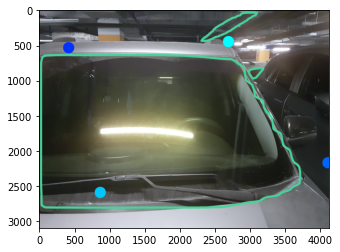

In [57]:
cv2.circle(demo_image, top_right, 80, (0, 255, 255), -1)
cv2.circle(demo_image, top_left, 80, (0, 50, 255), -1)
cv2.circle(demo_image, bottom_left, 80, (0, 200, 255), -1)
cv2.circle(demo_image, bottom_right, 80, (0, 100, 255), -1)
#cv2.circle(image,func_that_returns_the_optimal_point((0,0),(0,image.shape[0]),contourss),8,(0,0,255),-1)
#cv2.circle(image,(cX,cY),8,(0,255,255),-1)
# cv2.startWindowThread()
# cv2.namedWindow("preview")
# cv2.imshow("preview", demo_image)
# cv2.waitKey(0)
plt.imshow(demo_image)

In [58]:
def get_inverse_perspective(perspective_matrix: np.array)-> np.array:
    #Take 5 homogenous points on the floor(Unit is in Meters)
    pts_dst = np.array([[0,0,0,1],
                      [0,1,0,1],
                      [1,0,0,1],
                      [1,1,0,1],
                      [0,0,0,1]
                    ])
    #Obtain respective homogenous points on the image plane
    pts_src = (perspective_matrix @ pts_dst.T).T
    #convert homogenous coordinates to cartesian coorndinates
    pts_src_cart = np.array([[x/w, y/w] for x,y,w in pts_src])
    pts_dst_cart = np.array([[x/w, y/w] for x,y,z,w in pts_dst])
    #find the 3x3 Homography Matrix for transforming image plane to floor plane
    H, status = cv2.findHomography(pts_src_cart, pts_dst_cart)
    return H 

In [60]:
def project_to_floor(image_coordinates: List[int], H: np.array) -> List[int]: 
  """
  This method takes the Homography matrix and the 2d image cartesian coordinates. It returns the (x, y)
  cartesian coordinates in 3d cartesian world coordinates on floor plane(at z=0). Notice that z coordinate is omitted
  here and added inside the tracking funtion. 
  
  Parameters
  ----------
  image_coordinates: 2d pixel coordinates (x,y)
  h: 3x3 Homography matrix np.array[3x3]
  Returns
  ----------
  floor_coordinates: List of x, y coordinates in 3d world of same pixel on floor plane i.e. (x,y,z) Considering z=0 and 
  ommitted here.
  """
  #adding 1 for homogenous coordinate system
  x, y, w = H @ np.array([[*image_coordinates, 1]]).T
  return [x/w, y/w]

p = np.random.rand(3,4)
H = get_inverse_perspective(p)
src_point = (5,10)
dst_point = project_to_floor(src_point, H)

In [62]:
print(project_to_floor(top_right,H))
print(project_to_floor(top_left,H))
print(project_to_floor(bottom_right,H))
print(project_to_floor(bottom_left,H))


[array([-0.29718971]), array([0.46906303])]
[array([-2.32579151]), array([3.8640914])]
[array([-0.92313888]), array([1.51597688])]
[array([-6.34142353]), array([10.58003472])]


In [44]:


def plot_crack(image,segms,labels,scores):
    for idx,s in enumerate(segms):
        #color = 
        #color = mask_colors[labels[idx]]
        #color = color.tolist()
        score = round(scores[idx],2)
        #print(color)
        #print(s)
        
        contours, _ = cv2.findContours(np.array(s).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) == 0:
            continue
            
        c = max(contours,key=cv2.contourArea)
        
        M = cv2.moments(c)
        if M["m00"] != 0:
            cy = int(M["m01"] / M["m00"])
        else:
            cy = c[0][0][1]
            
        cx = [idi for idi,i in enumerate(s[cy]) if i][0]        
        
        image = cv2.drawContours(image,contours,-1,(255,0,255),2)
        image = cv2.putText(image,str(score)+'|crack |'+str(s.sum()),(cx+10,cy),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,255),2,cv2.LINE_AA)
    
    return image

In [5]:
def nms_float_fast(dets, thresh):
    """
    # It's different from original nms because we have float coordinates on range [0; 1]
    :param dets: numpy array of boxes with shape: (N, 5). Order: x1, y1, x2, y2, score. All variables in range [0; 1]
    :param thresh: IoU value for boxes
    :return: index of boxes to keep
    """
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    
    scores = dets[:,4]
    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        #print(i)
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
       
        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= thresh)[0]
        #print(inds)
        #print(order)
        order = order[inds + 1]

    return keep


#def carpart_inference(model,image,confident_score):
#    result = inference_detector(model,image.copy())
#    _,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model,image.copy(),result,score_thr=confident_score)
    
#    return pred_boxes,pred_segms,pred_labels,pred_scores

def damage_inference(image,confident_score):
    crack_result = inference_detector(crack_model,image.copy())
    scratch_result = inference_detector(scratch_model,image.copy())
    
    crack_result[0][0] = np.concatenate((crack_result[0][0],scratch_result[0][0]))
    crack_result[1][0].extend(scratch_result[1][0])
    #print('result :',crack_result[0][0])
    h,w = image.shape[:2]
    #print(h,w)
    boxes = crack_result[0][0]
    for idx,b in enumerate(boxes):
        boxes[idx][0] = boxes[idx][0] / w 
        boxes[idx][1] = boxes[idx][1] / h
        boxes[idx][2] = boxes[idx][2] / w
        boxes[idx][3] = boxes[idx][3] / h
    #print(boxes[:,4])
    #print(boxes)
    keep = nms_float_fast(boxes,0.4)
    #print(keep)
    crack_result[0][0] = boxes[keep]
    #print('segms :',crack_result[1][0])
    crack_result[1][0] = np.asarray(crack_result[1][0])[keep].tolist()
    
    out_image,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(crack_model,image.copy(),crack_result,score_thr=confident_score)
    
    return pred_boxes,pred_segms,pred_labels,pred_scores



def damage_inference_v2(image,crack_confident,scratch_confident):    
    def filter_confident(det_result,confident):
        boxes = det_result[0][0]
        keep = np.where(boxes[:,4] >= confident)[0]
        det_result[0][0] = boxes[keep]
        det_result[1][0] = np.asarray(det_result[1][0])[keep].tolist()
        
        return det_result
    
    crack_result = inference_detector(crack_model,image.copy())
    crack_result = filter_confident(crack_result,crack_confident)
    
    scratch_result = inference_detector(scratch_model,image.copy())
    scratch_result = filter_confident(scratch_result,scratch_confident)
    
    crack_result[0][0] = np.concatenate((crack_result[0][0],scratch_result[0][0]))
    crack_result[1][0].extend(scratch_result[1][0])

    h,w = image.shape[:2]
    boxes = crack_result[0][0]
    
    for idx,b in enumerate(boxes):
        boxes[idx][0] = boxes[idx][0] / w 
        boxes[idx][1] = boxes[idx][1] / h
        boxes[idx][2] = boxes[idx][2] / w
        boxes[idx][3] = boxes[idx][3] / h

    keep = nms_float_fast(boxes,0.3)
    crack_result[0][0] = boxes[keep]
    crack_result[1][0] = np.asarray(crack_result[1][0])[keep].tolist()
    
    out_image,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(crack_model,image.copy(),crack_result,score_thr=0.01)
    
    if pred_segms is None:
        pred_segms = []
    return pred_boxes,pred_segms,pred_labels,pred_scores

def glass_broken_inference(image,confident):
    result = inference_detector(glass_broken_model,image.copy())
    _,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(glass_broken_model,image.copy(),result,score_thr=confident)
    
    if pred_segms is None :
        pred_segms = []
    
    return pred_boxes,pred_segms,pred_labels,pred_scores
    
def windshield_inference(image):
    ####### car part inference
    carpart_result = single_model_inference(carpart_model,image,0.7)
    #print(*carpart_result[1:3])
    windshield_semgs, windshield_labels = check_windshield(*carpart_result[1:3]) 
    
    ###### damge inference 
    #boxes,segms,labels,scores = damage_inference_v2(image.copy(),crack_confident=0.64,scratch_confident=0.62)
    boxes,segms,labels,scores = glass_broken_inference(image,confident=0.6)
    ###### post processing
    # check inside windshield
    
    if len(windshield_semgs) > 0 and len(segms) > 0:
        check = [False for _ in range(len(segms))]
        for idx,s in enumerate(segms): 
            if s.sum() == 0:
                continue
            intersect_check = [np.logical_and(s,ws).sum()/s.sum() > 0.7 for ws in windshield_semgs]
            #print(s.sum(),[np.logical_and(s,ws).sum()/s.sum() for ws in windshield_semgs])
            intersect_check = sum(intersect_check) > 0
            check[idx] = intersect_check

        boxes = np.array(boxes)[check]
        #print(len(segms),check)
        segms = segms[check]
        labels = labels[check]
        scores = scores[check]
        
    out = plot_windshield(image,windshield_semgs,windshield_labels)
    out = plot_crack(out,segms,labels,scores)
    
    return out

In [ ]:
'''
image = cv2.imread(files[145])

#damage_inference_v2(image,0.7,0.5)
plt.figure(figsize=(15,10))
show = cv2.cvtColor(np.hstack((image,windshield_inference(image.copy()))),cv2.COLOR_RGB2BGR)
plt.figure(figsize=(15,10))
plt.imshow(show)
'''
i = data['images'][0]
image = cv2.imread(str(path/'images'/i['file_name']))
annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in data['annotations'] if a['image_id']==i['id']]
new_image = cv2.drawContours(image.copy(),annos,-1,(255,255,0))
plt.figure(figsize=(15,10))
plt.imshow(new_image)

In [ ]:
out_folder = 'windshield_test'
Path(out_folder).mkdir(parents=True,exist_ok=True)
for f in tqdm(data['images']):
    #print(idx)
    img = cv2.imread(str(path/'images'/f['file_name']))
    annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in data['annotations'] if a['image_id']==f['id']]
    new_img = cv2.drawContours(img.copy(),annos,-1,(255,0,255))
    img = np.hstack((new_img,windshield_inference(img.copy())))
    cv2.imwrite(out_folder+'/'+f['file_name'],img)

In [ ]:
path = Path('/mmdetection/data/tmp/windshield/instagram')
files = [str(i) for i in path.iterdir() if i.is_file()]
print(files)


out_folder = 'windshield_instagram'
Path(out_folder).mkdir(parents=True,exist_ok=True)
for f in tqdm(files):
    #print(idx)
    img = cv2.imread(f)
    #annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in data['annotations'] if a['image_id']==f['id']]
    #new_img = cv2.drawContours(img.copy(),annos,-1,(255,0,255))
    img = np.hstack((img,windshield_inference(img.copy())))
    cv2.imwrite(out_folder+'/'+f[f.rfind('/')+1:],img)

In [ ]:
s= '/mmdetection/data/tmp/windshield/instagram/119461813_3367613256685024_1741302932519352110_n.jpg'
s[s.rfind('/')+1:]

In [ ]:
# image file name need to be annotate
output = []
out_folder = 'windshield_anno'
Path(out_folder).mkdir(parents=True,exist_ok=True)

no_folder = 'windshield_no'
Path(no_folder).mkdir(parents=True,exist_ok=True)
for f in tqdm(files):
    #print(idx)
    img = cv2.imread(f)
    file_name = f[f.rfind('/')+1:]
    
    carpart_result = single_model_inference(carpart_model,img,0.9)
    windshield_semgs, windshield_labels = check_windshield(*carpart_result[1:3]) 
    
    boxes,segms,labels,scores = glass_broken_inference(img,confident=0.6)
    
    # model unable to detect any damages -> need to be annotate
    if len(segms) == 0:
        output.append(f)
        
        cv2.imwrite(out_folder+'/'+file_name,cv2.imread('windshield_instagram/'+file_name))
        continue
    
    # damage too large -> no
    areas_check = [s.sum() > 50116.5 for s in segms]
    if sum(areas_check) > 0:
        cv2.imwrite(no_folder+'/'+file_name,cv2.imread('windshield_instagram/'+file_name))
        continue
    
    # image from closed distance and it not bigger than 0.4 area of images
    if len(windshield_semgs) == 0:
        area = img.shape[0]*img.shape[1]
        ratios = [s.sum()/area > 0.4  for s in segms]
        check = sum(ratios) == 0
        if check :
            output.append(f)
            cv2.imwrite(out_folder+'/'+file_name,cv2.imread('windshield_instagram/'+file_name))
            continue
    
    # if there is any damage in windshield and smaller than 0.1*area winshield -> need to be annotate
    main_ws = max(windshield_semgs,key=lambda p:p.sum())
    
    intersect_check = [np.logical_and(s,main_ws).sum() / s.sum() > 0.6 for s in segms if s.sum() > 0 and main_ws.sum() > 0]
    size_check = [np.logical_and(s,main_ws).sum() / main_ws.sum() > 0.6 for s in segms if s.sum() > 0 and main_ws.sum() > 0]
    
    # check nothing in main windshield -> potential FP windshield -> need annotation review
    if sum(intersect_check) == 0:
        cv2.imwrite(out_folder+'/'+file_name,cv2.imread('windshield_instagram/'+file_name))
        continue
    
    # check if damage too big -> no
    if np.logical_and(intersect_check,size_check).sum() > 0:
        cv2.imwrite(no_folder+'/'+file_name,cv2.imread('windshield_instagram/'+file_name))
        continue
    
    cv2.imwrite(out_folder+'/'+file_name,cv2.imread('windshield_instagram/'+file_name))

In [ ]:
annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in total['annotations']]
areas = np.array([cv2.contourArea(a) for a in annos])
bound = 1
print(np.quantile(areas,bound))

a,b,c = plt.hist(areas[areas < np.quantile(areas,bound)],bins=100)

In [ ]:
f = '/mmdetection/data/tmp/windshield/real_data_3/20220105_173900.jpg'
image = cv2.imread(f)
#plt.imshow(image)
carpart_result = single_model_inference(carpart_model,image,0.7)
    #print(*carpart_result[1:3])
windshield_semgs, windshield_labels = check_windshield(*carpart_result[1:3]) 
plt.imshow(windshield_semgs[0])

In [ ]:
contours, _ = cv2.findContours(np.array(windshield_semgs[0]).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img = cv2.drawContours(image.copy(),contours,0,(255,255,0),2)
plt.imshow(img)

In [6]:
import math
from scipy import spatial

# find index of hightest corner of windshield
def high_of_point(point):
    return point[0][1]

# get upper line (index of highest point + its offset -> upper line)
#input : contour
#output : index + offset
def get_upper_line(cnt):
    len_cnt = len(cnt)
    highest_corner = min(cnt,key=high_of_point) 
    index = [idx for idx,p in enumerate(cnt) if (p == highest_corner).sum() == 2][0]

    p1 = cnt[(index+1)%len_cnt]
    p2 = cnt[(index-1)%len_cnt]

    norm_p1 = p1 - cnt[index]
    norm_p2 = p2 - cnt[index]

    tan_p1 = norm_p1[0][1] / norm_p1[0][0]
    tan_p2 = norm_p2[0][1] / norm_p2[0][0]

    ## upline is highest corner and its offset
    if abs(tan_p1) < abs(tan_p2):
        offset = 1
    else:
        offset = -1

    return index, offset

In [21]:
def get_angle(a,b,c): #a,b,c are 3 points
    vector_ba = a-b 
    vector_bc = c-b

    cosin = 1 - spatial.distance.cosine(vector_ba,vector_bc)

    return math.acos(cosin)

def distance(p1,p2):
    vector_p = p2-p1

    return math.sqrt(np.power(vector_p,2).sum()) 

#intersect point of two lines p1p2 and p3p4
#https://answers.opencv.org/question/9511/how-to-find-the-intersection-point-of-two-lines/
def cross_of_two_lines(p1,p2,p3,p4):
    #print('line 1 ',p1,p2)
    #print('line 2 ',p3,p4)
    x = p3-p1
    d1 = p2-p1
    d2 = p4-p3
#     print(d1, d1.shape)

    cross = d1[0][0]*d2[0][1] - d1[0][1]*d2[0][0]

    projection = (x[0][0]*d2[0][1]-x[0][1]*d2[0][0]) / cross

    intersect = (p1 + projection*d1).astype(np.int32)
    #print('cross : ',intersect)
    return intersect

# verify exception of upper line 
## angle > 150 :
#### side_len / upper_width > 0.3  -> remove point problem else add point problem
## agle > 140 and side_len / upper_width < alpha -> add point problem + alpha = ???

In [25]:
p1 = np.array([[-3,1]])
print(p1.shape)
p2 = np.array([[-9,-3]])
p3 = np.array([[-6,0]])
p4 = np.array([[-2,4]])
cross_of_two_lines(p1,p2,p3,p4)


(1, 2)


array([[-9, -3]], dtype=int32)

In [ ]:
def verify_upper_line(cnt,index,offset):
    len_cnt = len(cnt)
    upper_width = distance(cnt[index],cnt[(index+offset)%len_cnt])
    new_cnt = cnt.copy()
    
    angles = []
    side_heights = []
    
    for zone_id in range(0,2):
        side_point_id = (zone_id == 0)*(index-offset) + (zone_id == 1)*(index+2*offset)
        conern_id = (zone_id == 0)*(index) + (zone_id == 1)*(index+offset)
        
        angle = get_angle(cnt[(index-offset+zone_id*offset)%len_cnt],cnt[(index+zone_id*offset)%len_cnt],
                          cnt[(index+offset+zone_id*offset)%len_cnt])
        side_height = distance(cnt[side_point_id%len_cnt],cnt[conern_id%len_cnt])
        
        angles.append(angle)
        side_heights.append(side_height)
    
    delta = abs(angles[0] - angles[1])
    camera_angle = (math.pi/2 - delta)/math.pi*180
    print('angles : ',angles[0]/math.pi*180,angles[1]/math.pi*180)
    for zone_id in range(0,2):
        angle = angles[zone_id]
        #print('inside verify angle: ', angle/math.pi*180)

        side_point_id = (zone_id == 0)*(index-offset) + (zone_id == 1)*(index+2*offset)
        conern_id = (zone_id == 0)*(index) + (zone_id == 1)*(index+offset)

        side_height = side_heights[zone_id]
        side_line_ratio = side_height / side_heights[1-zone_id]

        ## ratio check 
        ratio = side_height/upper_width
        print('verify angle : ',round(angle/math.pi*180,2),' ratio : ',round(ratio,2),' ratio side line  : ',
              side_line_ratio,' delta angle : ',round(delta/math.pi*180,2))
        #print('ratio : ',side_height/upper_width)

        if angle/math.pi*180 > 150 :
            ## remove conern
            if ratio > 0.4:
                if sum(np.array(angles) > math.pi/2) < 2  :
                    #print('yo 1')
                    return cnt,index,offset
                
                if delta/math.pi*180 < 18 and angle/math.pi*180 < 155 : 
                    print('yo 2',delta/math.pi*180)
                    return cnt,index,offset
                print('delete problem 1 ')
                new_cnt = np.delete(new_cnt,conern_id%len_cnt,0)
            else:    
                ## add point
                print('add problem 1')
                low_conern_id = (zone_id == 0)*(index-2*offset) + (zone_id == 1)*(index+3*offset)
                new_point = cross_of_two_lines(cnt[low_conern_id%len_cnt],cnt[side_point_id%len_cnt],cnt[index],
                                               cnt[(index+offset)%len_cnt])

                new_cnt[side_point_id%len_cnt] = new_point
                new_cnt = np.delete(new_cnt,conern_id%len_cnt,0)

            return new_cnt,*get_upper_line(new_cnt)
        
        if side_line_ratio < 0.31 :
            print('delete corner problem')
            low_conern_id = (zone_id == 0)*(index-offset) + (zone_id == 1)*(index+2*offset)
            #print('debug : ',conern_id%len_cnt,low_conern_id%len_cnt,len_cnt,index,offset)
            new_cnt = np.delete(new_cnt,low_conern_id%len_cnt,0)
            
            return new_cnt,*get_upper_line(new_cnt)
        elif side_line_ratio < 0.55 and (abs(angles[0]-angles[1])/math.pi*180 > 30 or ratio < 0.2):
            print('add problem 2 ')
            low_conern_id = (zone_id == 0)*(index-2*offset) + (zone_id == 1)*(index+3*offset)
            new_point = cross_of_two_lines(cnt[low_conern_id%len_cnt],cnt[side_point_id%len_cnt],cnt[index],
                                           cnt[(index+offset)%len_cnt])

            new_cnt[side_point_id%len_cnt] = new_point
            new_cnt = np.delete(new_cnt,conern_id%len_cnt,0)
            
            return new_cnt,*get_upper_line(new_cnt)
        
        if angle/math.pi*180 > 144 and ratio < 0.4 and abs(side_line_ratio-1) > 0.1:
            print('add problem 3')
            low_conern_id = (zone_id == 0)*(index-2*offset) + (zone_id == 1)*(index+3*offset)
            new_point = cross_of_two_lines(cnt[low_conern_id%len_cnt],cnt[side_point_id%len_cnt],cnt[index],
                                           cnt[(index+offset)%len_cnt])

            new_cnt[side_point_id%len_cnt] = new_point
            new_cnt = np.delete(new_cnt,conern_id%len_cnt,0)

            return new_cnt,*get_upper_line(new_cnt)
        #side_point = cnt[side_point_id%len_cnt]

        #print('side point : ',side_point)

    return cnt,index,offset

In [ ]:
def verify_side_line(cnt,index,offset,width):
    len_cnt = len(cnt)
    new_cnt= cnt.copy()
    remove_ids = []
    side_lines = []
    
    for zone_id in range(0,2):
        conern_id = (zone_id == 0)*(index) + (zone_id==1)*(index+offset)
        under_conern_id = (zone_id == 0)*(index-offset) + (zone_id==1)*(index+2*offset)
        
        side_line = distance(cnt[under_conern_id%len_cnt],cnt[conern_id%len_cnt])
        side_lines.append(side_line)
    
    for zone_id in range(0,2):
        conern_id = (zone_id == 0)*(index) + (zone_id==1)*(index+offset)
        under_conern_id = (zone_id == 0)*(index-offset) + (zone_id==1)*(index+2*offset)
        check_point_id = (zone_id == 0)*(index-2*offset) + (zone_id==1)*(index+3*offset)
        
        #print('debug ratio ...',side_lines[zone_id] / side_lines[1-zone_id])
        
        if side_lines[zone_id] / side_lines[1-zone_id] < 0.4:
            remove_ids.append(under_conern_id%len_cnt)
            continue
        
        under_concern_angle = get_angle(cnt[conern_id%len_cnt],cnt[under_conern_id%len_cnt],
                                        cnt[check_point_id%len_cnt])
        
        near_border = min(cnt[under_conern_id%len_cnt][0][0],width-cnt[under_conern_id%len_cnt][0][0])
        
        check_near_border = near_border - 10 < 0
        
        check_point_vector_angle = get_angle(cnt[under_conern_id%len_cnt],cnt[check_point_id%len_cnt],
                                            cnt[check_point_id%len_cnt]+[[1,0]])
        
        check_angle = abs(check_point_vector_angle/math.pi*180 - 90) > 6
        
        print('debug side line angle: ',under_concern_angle/math.pi*180,check_point_vector_angle/math.pi*180)
        
        if math.ceil(under_concern_angle/math.pi*180) >= 160:
            remove_ids.append(under_conern_id%len_cnt)
            if not check_angle : 
                print('yolo!!!!')
            continue
        
        if math.ceil(under_concern_angle/math.pi*180) >= 150:
            if check_near_border and not check_angle:
                continue
            else : 
                remove_ids.append(under_conern_id%len_cnt)
        
    
    new_cnt = np.delete(new_cnt,remove_ids,0)
    
    return new_cnt,*get_upper_line(new_cnt)

In [ ]:
## angle of vector1 and vector2 -> find vector2
def find_vector_from_angle(vector1,angle,vector_check):
    theta = np.power(vector1,2).sum() * math.cos(angle)**2
    a = vector1[0][0]**2 - theta
    b = 2*vector1[0][0]*vector1[0][1]
    c = vector1[0][1]**2 - theta

    result = np.roots([a,b,c])

    new_vec1 = np.array([[result[0],1]])
    check1 = abs(1 - spatial.distance.cosine(vector_check,new_vec1))
    new_vec2 = np.array([[result[1],1]])
    check2 = abs(1 - spatial.distance.cosine(vector_check,new_vec2))

    #print(check1,check2)

    if check1 > check2 :
        return new_vec1
    else:
        return new_vec2
    
### find magnitude of adjust_vector to rotate main_vector angle
def find_adjust_magnitude(adjust_vector,main_vector,adjsut_angle):
    # scalar of adjust_vector and main_vector
    x = (adjust_vector*main_vector).sum()

    # power 2 of length adjust_vector
    y = np.power(adjust_vector,2).sum()

    # power 2 of length main_vector
    z = np.power(main_vector,2).sum()

    ## quadratic
    a = x**2- math.cos(adjsut_angle)*y*z
    b = 2*x*z-2*math.cos(adjsut_angle)*x*z
    c = z**2 - math.cos(adjsut_angle)*z**2

    result = np.roots([a,b,c])

    print('debug : ',result)

    if sum(result > 0) == 1:
        return result[result>0][0]
    else:
        return min(result)

## input image, contour, start point, projection vector
## ouput height of windshield at start point
def find_windshield_height_at_point(img,cnt,point,projection):
    mask = np.zeros_like(img[:,:,0])
    i_vector = projection / math.sqrt(np.power(projection,2).sum())

    contour_mask = cv2.drawContours(mask.copy(),[cnt],-1,1,4)
    line_mask = cv2.line(mask.copy(),(point+10*i_vector).astype(np.int32)[0],
                         (point+max(img.shape[:2])*i_vector).astype(np.int32)[0],1,1)

    intersect = np.logical_and(contour_mask,line_mask)
    max_index = np.argmax(intersect)
    intersect_point = np.array([[int(max_index%mask.shape[1]),int(max_index/mask.shape[1])]])

    ws_height = distance(point,intersect_point)
    return ws_height


In [ ]:
def build_classifier_model(model_path):
    model = models.resnet18(pretrained=False)
    num_feature = model.fc.in_features
    model.fc = nn.Linear(in_features=num_feature, out_features=2, bias=True)
#     model.load_state_dict(torch.load('driver_classifier.pth'))
    model.load_state_dict(torch.load(model_path))
   
    model = model.to(torch.device('cuda:2'))
    model.eval()
    
    return model

def classify(model,img0,img1,device,default=None):
    softmax = nn.Softmax(dim=1)
    
    def to_tensor(img):
        inp = F.to_tensor(img)
        inp = inp.unsqueeze(0)
        inp = inp.to(device)
        
        return inp
    
    def driver_prob_infer(inp):
        pred = softmax(model(inp)).cpu().detach().numpy()
        prob = pred[0][0]
        
        return prob
    
    img0 = to_tensor(img0)
    img1 = to_tensor(img1)
    
    prob0 = driver_prob_infer(img0)
    prob1 = driver_prob_infer(img1)
    
    
    
    alpha_check_sum = 0.1
    check_sum = abs(prob0+prob1 - 1) < alpha_check_sum
    
    print('prob : ',prob0,prob1,' check_sum : ',check_sum,' default : ',default)
    
    if check_sum : 
        return 0*(prob0 >= prob1) + 1*(prob0 < prob1)
    
    if default is not None:
        return default
    
    return 0*(prob0 >= prob1) + 1*(prob0 < prob1)

In [ ]:
def recenter(cnt,center,angles,vector_upper_line):
    length_upper_line = math.sqrt(np.power(vector_upper_line,2).sum())
    
    delta = abs(angles[0] - angles[1])
    camera_angle = math.pi/2 - delta
    delta_length = length_upper_line*(1/math.sin(camera_angle) - 1)
    adjust_center_vector = vector_upper_line*((1-angles[0]/angles[1] > 0)*1 - (1-angles[0]/angles[1] <= 0))
    adjust_ratio = 0.8 
    
    ## re calculate adjsut_ratio for delta  > 45 ???
    # TODO 
    if delta/math.pi*180 > 60:
        adjust_ratio = 0.1
    elif delta/math.pi*180 > 45:
        adjust_ratio = 0.16
    elif delta/math.pi*180 > 40:
        adjust_ratio = 0.5
    elif delta/math.pi*180 < 20:
        adjust_ratio = 1
        
    new_center = (center + adjust_ratio*adjust_center_vector/length_upper_line*delta_length).astype(np.int32)
    
    return new_center

## find balance line from center
def balance_upper_line(cnt,index,offset,center):
    len_cnt = len(cnt)
    vector = cnt[(index+offset)%len_cnt]-cnt[index]
    upper_line_angle = abs(math.atan(vector[0][1]/vector[0][0])/math.pi*180)
    print('debug balance angle  : ',upper_line_angle)
    
    ## check allign of upper line and under line ?? 
    
    if upper_line_angle < 1 :
        return cnt
    
    if upper_line_angle > 6:
        under_line_vector = cnt[(index+2*offset)%len_cnt]-cnt[(index-offset)%len_cnt]
        under_line_vector = np.array(under_line_vector).squeeze()
        vector = np.array(vector).squeeze()
        
        ## calculate angle of 2 vector
        base1 = under_line_vector / np.linalg.norm(under_line_vector)
        base2 = vector / np.linalg.norm(vector)
        angle = np.arccos(np.dot(base1,base2)) / math.pi*180
        
        print('align angle : ',angle)
        if angle < 10 :
            return cnt
        
        
    ## balance line
    new_point = np.array(center) + [[10,0]]
    
    for zone_id in range(0,2):
        # side line = corner_point + under_corner_point
        corner_point_id = (zone_id==0)*index + (zone_id==1)*(index+offset)
        low_conern_id = (zone_id==0)*(index-offset) + (zone_id==1)*(index+2*offset)
        
        cnt[corner_point_id%len_cnt] = cross_of_two_lines(center,new_point,
                                                          cnt[corner_point_id%len_cnt],cnt[low_conern_id%len_cnt])
    
    return cnt

In [ ]:
def driver_zone(driver_model,image,ws_cnt):
    image_width = image.shape[1]
    # simplify the contour
    
    peri = cv2.arcLength(ws_cnt, True) #Contour Perimeter, True indicates shape is a closed contour
    #print('ws cnt :',peri, 0.02 * peri)
    approx = cv2.approxPolyDP(ws_cnt, 0.01 * peri, True)
    LEN_APP = len(approx)
    #print('app : ',LEN_APP,'ws cnt :',peri, 0.02 * peri)
    # find upper line and verify
    # review again some case
    origin_app_image = cv2.drawContours(image.copy(),[approx],-1,(255,0,0),3)
    index, offset = get_upper_line(approx)
    approx,index,offset = verify_upper_line(approx,index,offset)
    approx,index,offset = verify_upper_line(approx,index,offset)
    
    ## verify side line
    approx,index,offset = verify_side_line(approx,index,offset,image_width)
    
    LEN_APP = len(approx)
    print('app : ',LEN_APP,'ws cnt :',peri, 0.02 * peri)
    
    # draw verified contour 
    #draw_image = cv2.drawContours(image.copy(),[approx],-1,(255,0,0),3)
    
    ## debug 
    vector = approx[(index+offset)%LEN_APP]-approx[index]
    print(f'upper line angle : {math.atan(vector[0][1]/vector[0][0])/math.pi*180:.2f}')

    ## find center upper line according to pixel wise
    center = ((approx[index] + approx[(index+offset)%LEN_APP]) / 2).astype(np.int32)
    print('center : ',center)
    #draw_image = cv2.circle(draw_image,center[0],radius=25, color=(255, 255, 0), thickness=-1)
    
    # balance 2 concern points
    # todo 
    approx = balance_upper_line(approx.copy(),index,offset,center)
    draw_image = cv2.drawContours(image.copy(),[approx],-1,(0,255,255),3)
    
    ## vector of upper line
    vector = approx[(index+offset)%LEN_APP]-approx[index]
    length_vector = math.sqrt(np.power(vector,2).sum()) # uper line width
    
    # vector of 2 side lines in windshield
    side_vectors = [approx[index] - approx[(index-offset)%LEN_APP],approx[(index+offset)%LEN_APP] - approx[(index+2*offset)%LEN_APP]]
    side1 = distance(approx[index], approx[(index-offset)%LEN_APP])
    side2 = distance(approx[(index+offset)%LEN_APP] , approx[(index+2*offset)%LEN_APP])
    ratio_side = side1/side2
    ratio_side = (ratio_side < 1)*(1/ratio_side) + (ratio_side >= 1)*ratio_side
    
    draw_image = cv2.line(draw_image,approx[index][0],approx[(index-offset)%LEN_APP][0],(255,255,0),15)
    draw_image = cv2.line(draw_image,approx[(index+offset)%LEN_APP][0],approx[(index+2*offset)%LEN_APP][0],(255,255,0),15)
    
    # angles of 2 upper conern in windshield
    angles = []
    for zone_id in range(0,2):
        angle = get_angle(approx[(index-offset+zone_id*offset)%LEN_APP],approx[(index+zone_id*offset)%LEN_APP],
                          approx[(index+offset+zone_id*offset)%LEN_APP])
            
        angles.append(angle)
        #draw_image = cv2.putText(draw_image,str(angle/math.pi*180),(0,150*(zone_id+1)),cv2.FONT_HERSHEY_SIMPLEX,5,
        #                         (255,0,255),2, cv2.LINE_AA)
        print('angle : ', angle/math.pi*180)
    
    # recenter base on user's camera angle
    angles = np.array(angles)
    delta = abs(angles[0] - angles[1])
    new_center = recenter(approx,center,angles,vector)
    
    ## balance upper line 
    #new_app_2 = balance_upper_line(approx.copy(),index,offset,new_center)
    #draw_image = cv2.drawContours(draw_image,[new_app_2],-1,(0,0,255),3)
    #print('new center : ',new_center,recenter(approx,center,angles,vector))
    
    ## center folowing bigger angles
    arg_max_angle = np.argmax(angles)
    center_angle = angles[arg_max_angle]
    #center_vector = side_vectors[arg_max_angle]
    center_vector = find_vector_from_angle(vector,center_angle,side_vectors[arg_max_angle])
    ws_height = find_windshield_height_at_point(image,approx,new_center,center_vector)
    under_center = new_center + 0.25*ws_height*center_vector/math.sqrt(np.power(center_vector,2).sum())
    under_center = under_center.astype(np.int32)
    
    adjust_vector = approx[(index + (1-arg_max_angle)*offset)%LEN_APP] - new_center
    adjust_angle = center_angle - math.pi/2 - 0.2*delta
    magnetude = find_adjust_magnitude(adjust_vector,under_center-new_center,adjust_angle)
    new_v = under_center-new_center + magnetude*adjust_vector
    #new_under = new_center+new_v
    #new_under = new_under.astype(np.int32)
     
    l1 = distance(approx[index],new_center)
    c1 = (approx[index]+(1-0.2)*l1*vector/length_vector).astype(np.int32)
    c2 = (c1 + 0.2*vector).astype(np.int32)
    c3 = (c1 + new_v).astype(np.int32)
    c4 = (c2 + new_v).astype(np.int32)
    
    camera_area = np.array([c1,c2,c4,c3])
    
    ## extract sub image for classification
    ##
    def four_point_transform(pts):
        widthA = distance(pts[0],pts[1])
        widthB = distance(pts[2],pts[3])
        max_width = max(widthA,widthB)
        
        heightA = distance(pts[0],pts[3])
        heightB = distance(pts[1],pts[2])
        max_height = max(heightA, heightB)
        
        #print(pts)
        dst = np.array([[0, 0],
                        [max_width - 1, 0],
                        [max_width - 1, max_height - 1],
                        [0, max_height - 1]], dtype = "float32")
        #print('debug : ',pts,dst)
        M = cv2.getPerspectiveTransform(pts, dst)
        warped = cv2.warpPerspective(image, M, (int(max_width), int(max_height)))
        warped = cv2.resize(warped, (256,256), interpolation = cv2.INTER_AREA)

        return warped
    
    #extract = 0
    
    #if extract:
    sub_height = find_windshield_height_at_point(image, approx,new_center,new_v)
    cut_point = new_center+sub_height*new_v/np.sqrt(np.power(new_v,2).sum())
    cut_point = cut_point.astype(np.int32)
    #draw_image = cv2.circle(draw_image,cut_point[0],radius=25, color=(0, 0, 255), thickness=4)
    #draw_image = cv2.line(draw_image,center[0],cut_point[0],(255,255,0),15)
    sub_pts0 = [approx[index][0],center[0],cut_point[0],approx[(index-offset)%LEN_APP][0]]
    sub_pts1 = [center[0],approx[(index+offset)%LEN_APP][0],approx[(index+2*offset)%LEN_APP][0],cut_point[0]]
    
    default_label = (approx[index][0][0] < approx[(index+offset)%LEN_APP][0][0])*1
    
    sub_img0 = four_point_transform(np.array(sub_pts0).astype(np.float32))
    sub_img1 = four_point_transform(np.array(sub_pts1).astype(np.float32))
    
    driver_id = classify(driver_model,sub_img0,sub_img1,torch.device('cuda:2'),default_label)
    
    
    #    return sub_img1,sub_img2
    #######################################
    
    

    ## debug 
    draw_image= cv2.drawContours(draw_image,[camera_area],-1,(0,255,0),3)
    draw_image = cv2.circle(draw_image,new_center[0],radius=25, color=(0, 0, 255), thickness=4)
    #p = np.array(new_center) + [[600,0]]
    #draw_image = cv2.line(draw_image,new_center[0],p[0], color=(0, 0, 255), thickness=4)
    draw_image = cv2.circle(draw_image,approx[index][0],radius=25, color=(0, 255, 255), thickness=-1)
    draw_image = cv2.circle(draw_image,approx[(index+offset)%LEN_APP][0],radius=25, color=(0, 0, 255), thickness=4)
    draw_image = cv2.putText(draw_image,f'detal : {delta/math.pi*180:.2f}, ratios : {1-angles[0]/angles[1]:.2f}',(0,150),cv2.FONT_HERSHEY_SIMPLEX,5,
                             (255,0,255),2, cv2.LINE_AA)
    #draw_image = cv2.putText(draw_image,f'delta length : {delta_length:.2f}',(0,150*2),cv2.FONT_HERSHEY_SIMPLEX,5,
    #                         (255,0,255),2, cv2.LINE_AA)
    draw_image = cv2.putText(draw_image,f'upper line angle : {math.atan(vector[0][1]/vector[0][0])/math.pi*180:.2f}',(0,150*3),cv2.FONT_HERSHEY_SIMPLEX,5,
                             (255,0,255),2, cv2.LINE_AA)
    draw_image = cv2.putText(draw_image,f'ratio side liens : {ratio_side:.2f}',(0,150*4),cv2.FONT_HERSHEY_SIMPLEX,5,
                             (255,0,255),2, cv2.LINE_AA)
    
    pre_image = draw_image.copy()
    
    ## locate driver / passenger area
    x_ratio = distance(approx[index],new_center) / distance(new_center,approx[(index+offset)%LEN_APP])
    
    # ratio of start point area to its coresponding half
    d_start_ratio = np.array([0.25,0.25])
    
    # angles of areas
    d_angles = np.copy(angles)
    vector_check_angles = side_vectors
    d_ajust_angles = abs(np.array(angles) - math.pi/2 - delta)
    
    if delta/math.pi*180 > 30 : 
        d_start_ratio[np.argmin(angles)] *=1.2
        d_angles[np.argmin(angles)] = 0.8*d_angles[1-np.argmin(angles)]
        vector_check_angles[np.argmin(angles)] = side_vectors[1-np.argmin(angles)]
        d_ajust_angles[np.argmin(angles)] = 0
    # ratio of width area to its corresponding half (default both sides will be 0.5)
    width_ratio = 1-2*d_start_ratio
    
    # angles related
    
    for zone_id in range(0,2): 
        if zone_id != driver_id:
            continue
            
        #print('width adjust ',width_ajust[zone_id])
        average_angle = angles[zone_id]
     
        check_vector = side_vectors[zone_id]
        # cos check_vector ,[[1,0]] = 0 -> use check_vector of other side
        cosin_check =  (check_vector*[[1,0]]).sum() / math.sqrt(np.power(check_vector,2).sum())
        #print('angle check :',d_angles[zone_id],vector_check_angles[zone_id])
        #print('cosin check : ',cosin_check)
        if abs(cosin_check) < 0.09:
            v1 = find_vector_from_angle(vector,0.9*d_angles[1-zone_id],vector_check_angles[1-zone_id])
            print('debug exception ')
        else:
            v1 = find_vector_from_angle(vector,d_angles[zone_id],vector_check_angles[zone_id])
        
        ## find height of windshield
        # find driver zone
        prefix_ratio = (zone_id==0)*d_start_ratio[zone_id]*x_ratio/(x_ratio+1)\
        +(zone_id==1)*(1-(d_start_ratio[zone_id]+width_ratio[zone_id])/(x_ratio+1))
                
        print('prefix : ',prefix_ratio,d_start_ratio,width_ratio,x_ratio)
        #projection = prefix_ratio * length_vector 
        z_point1 = (approx[index] + prefix_ratio*vector).astype(np.int32)
        w = (zone_id==0)*width_ratio[zone_id]*x_ratio/(x_ratio+1)+(zone_id==1)*width_ratio[zone_id]/(x_ratio+1)
        #w = w * width_ajust[zone_id]
        z_point2 = (approx[index] + (prefix_ratio+w)*vector).astype(np.int32)
        
        draw_image = cv2.circle(draw_image,z_point1[0],radius=15, color=(255, 0, 0), thickness=-1)
        draw_image = cv2.circle(draw_image,z_point2[0],radius=15, color=(255, 0, 0), thickness=-1)
        
        ws_height = find_windshield_height_at_point(image,approx,z_point1,v1)

        projection = (0.6*ws_height/(math.sqrt(np.power(v1,2).sum())))
        projection_vector = projection*v1
        
        ## draw pre adjustion image 
        #pre_point3 = np.array(z_point2+projection_vector).astype(np.int32)
        #pre_point4 = np.array(z_point1+projection_vector).astype(np.int32)
        
        #pre_zone = np.array([z_point1,z_point2,pre_point3,pre_point4])
        #pre_image = cv2.drawContours(pre_image,[pre_zone],-1,(255,255,0),3)
        
        ##? tune this vector : projection*v1 to center
        ## vector from z_point1 -> center
        adjust_vector = center - z_point1
        
        adjust_angle = d_ajust_angles[zone_id]
        print('***adjust angle : ',adjust_angle/math.pi*180,angles[zone_id]/math.pi*180,angles)
        
        #print('adjust angle : ',adjust_angle/math.pi*180)
        if abs(cosin_check) < 0.09:
            adjsut_magnitude = 0
        else:
            adjsut_magnitude = find_adjust_magnitude(adjust_vector,projection_vector,adjust_angle)
        projection_vector = projection_vector + adjsut_magnitude*adjust_vector
        leng_projection = math.sqrt(np.power(projection_vector,2).sum())
        
        ws_height = find_windshield_height_at_point(image,approx,z_point1,projection_vector)
        projection_vector = (0.6*ws_height/leng_projection) * projection_vector
        
        z_point3 = np.array(z_point2+projection_vector).astype(np.int32)
        z_point4 = np.array(z_point1+projection_vector).astype(np.int32)
        #print('check : ',distance(z_point1,z_point2),distance(z_point3,z_point4))
        zone = np.array([z_point1,z_point2,z_point3,z_point4])

        draw_image= cv2.drawContours(draw_image,[zone],-1,(255,200,0),3)

    return draw_image, pre_image,origin_app_image

(3096, 4128, 3)
ws_segm :  2
angles :  136.75839137999282 91.63244930369451
verify angle :  136.76  ratio :  0.77  ratio side line  :  1.2990132497493028  delta angle :  45.13
verify angle :  91.63  ratio :  0.59  ratio side line  :  0.7698150886397737  delta angle :  45.13
angles :  136.75839137999282 91.63244930369451
verify angle :  136.76  ratio :  0.77  ratio side line  :  1.2990132497493028  delta angle :  45.13
verify angle :  91.63  ratio :  0.59  ratio side line  :  0.7698150886397737  delta angle :  45.13
debug side line angle:  95.09906318436146 126.22923671726784
debug side line angle:  123.12126368615687 32.84040427147349
app :  7 ws cnt : 5809.537350654602 116.19074701309205
upper line angle : 1.91
center :  [[2113 1046]]
debug balance angle  :  1.9133087183778865
angle :  138.64046773323682
angle :  89.72683983117352
debug :  [-0.82127587  0.19965207]
prob :  0.0044105737 0.88610286  check_sum :  False  default :  1
prefix :  0.5976495726495727 [0.25 0.3 ] [0.5 0.4] 0.73

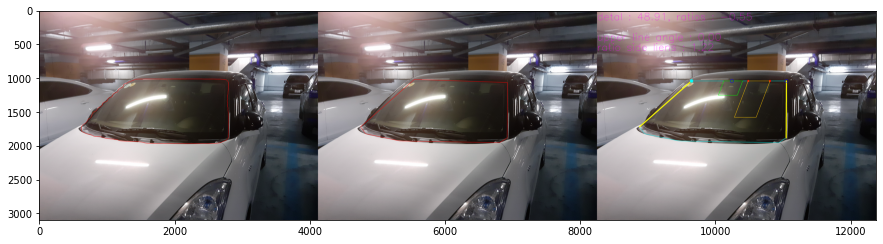

In [10]:

def driver_zone_detection(driver_model, image):
    ## windshield detection
    carpart_result = single_model_inference(carpart_model,image,0.6)
    windshield_semgs, windshield_labels = check_windshield(*carpart_result[1:3]) 
    print('ws_segm : ',len(windshield_semgs))
    if len(windshield_semgs) == 0 :
        return image, image,image
    
    ws_segm = max(windshield_semgs,key=lambda x : x.sum())
    contours, _ = cv2.findContours(np.array(ws_segm).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ws_contour = max(contours,key=cv2.contourArea)
    raw_cnt_image = cv2.drawContours(image.copy(),[ws_contour],-1,(255,0,0),3)
    
    ## detect driver zone
    output, pre_image,pre_app = driver_zone(driver_model,image,ws_contour)
    
    #result1 = np.hstack([image,raw_cnt_image])
    #result2 = np.hstack([pre_image,output])
    
    #return image, raw_cnt_image,image
d
#f = '/mmdetection/data/tmp/windshield/test_pipeline/38.jpg'
#f = '/mmdetection/data/tmp/windshield/real_data/20211102_201857.jpg'
#20211102_202310.jpg
#d_model = build_classifier_model('driver_classifier.pth')
d_model = build_classifier_model('../checkpoints/windshield/driver_classifier.pth')
#f = '/mmdetection/data/tmp/windshield/real_data_2/20211126_221901.jpg'
#f = '/mmdetection/data/tmp/windshield/total_real_data/20211126_223421.jpg'
f = '../data/windshield/total_real_data/20211126_222518.jpg'

#20211102_202250.jpg
#f = '/mmdetection/data/tmp/windshield/real_data/20211102_202250.jpg'
image = cv2.imread(f)
print(image.shape)
out_image,raw_cnt_image,out3 = driver_zone_detection(d_model,image)

plt.figure(figsize=(15,10))
plt.imshow(np.hstack([raw_cnt_image,out3,out_image]))

In [ ]:
20220105_173911.jpg

In [ ]:
f = '/mmdetection/data/tmp/windshield/test_pipeline/67929713_1239811336196307_106183138884619112_n.jpg'
image = cv2.imread(f)
out_image = driver_zone_detection(image)
plt.figure(figsize=(15,10))
plt.imshow(out_image)

In [ ]:
test_path = Path('/mmdetection/data/tmp/windshield/real_data')
files = [str(i) for i in test_path.iterdir() if i.is_file()]

out_folder = 'windshield_real_data_result'
Path(out_folder).mkdir(parents=True,exist_ok=True)

for f in tqdm(files):
    image = cv2.imread(f)
    print(f)
    out_image = driver_zone_detection(image)
    out_image = cv2.cvtColor(out_image,cv2.COLOR_BGR2RGB)
    cv2.imwrite(out_folder+'/'+f[f.rfind('/')+1:],out_image)


In [ ]:
### prepare classification dataset
import os
test_path = Path('/mmdetection/data/tmp/windshield/total_real_data')
files = [str(i) for i in test_path.iterdir() if i.is_file()]

out_folder = 'windshield_total_real_data'

Path(out_folder).mkdir(parents=True,exist_ok=True)

for f in tqdm(files):
    image = cv2.imread(f)
    f_name = os.path.basename(f)
    print(f)
    #print(f_name,f_name[:f_name.rfind('.')]+'__'+f_name[f_name.rfind('.'):])
    sub1,sub2,sub3 = driver_zone_detection(d_model,image)
    if sub1 is not None :
        cv2.imwrite(out_folder+'/'+f_name,np.hstack([sub2,sub3,sub1]))
        #cv2.imwrite(out_folder+'/'+f_name[:f_name.rfind('.')]+'_2'+f_name[f_name.rfind('.'):],sub2)
    #out_image = cv2.cvtColor(out_image,cv2.COLOR_BGR2RGB)
    #cv2.imwrite(out_folder+'/'+f[f.rfind('/')+1:],out_image)

In [ ]:
#20211126_223015.jpg 12
#20211102_202953 2.6
#20211102_203327 0.3
#20220105_200311 33
#20220105_200234 7.7
#20211102_203408 0.3
#20220106_084932 6.6 
# recheck un balance ????????
#20211126_223840.jpg * 
#20211126_224425.jpg

# should be delete problem, not add 
#20211126_221841.jpg

In [ ]:
#### mask fail
#20211126_223700.jpg

In [ ]:
## remove under concern problem
#20211126_224551.jpg
#20211102_202135.jpg
#20211102_202222.jpg
#20211102_202240.jpg
#20211102_202434.jpg
#20211102_202452.jpg
#20211102_202544.jpg
#20211102_202549.jpg
#20211102_202909.jpg
#20211102_202913.jpg
#20211126_221835.jpg  * 155 
#20211126_221850.jpg
#20211126_221911.jpg
#20211126_221935.jpg
#20211126_221940.jpg
#20211126_222023.jpg
#20211126_222037.jpg 
#20211126_222054.jpg * 162 
#20211126_222206.jpg ** 
#20211126_222226.jpg
#20211126_222346.jpg 
#20211126_222428.jpg * 160
#20211126_222450.jpg
#20211126_222508.jpg
#20211126_222619.jpg
#20211126_223015.jpg * 152
#20211126_223216.jpg
#20211126_223306.jpg
#20211126_223311.jpg
#20211126_223412.jpg +
#20211126_223416.jpg
#20211126_223517.jpg
#20211126_223523.jpg
#20211126_223630.jpg
#20211126_223738.jpg
#20211126_223742.jpg * 151
#20211126_223747.jpg
#20211126_224003.jpg *  149.27602767956907 106.09889616603145
#20211126_224055.jpg *  160 
#20211126_224414.jpg *  146     *******
#20211128_155019.jpg * 149 
#20211128_210314.jpg * 
#20220105_171541.jpg * 149








#ratio < 0.2 ?? 

# verify go wrong
#20211126_224510.jpg 150.7  ratio :  0.7751074124875185  ratio side line  :  1.4851066594195597 delete 1
#20211126_221940.jpg 153    ratio :  0.441533645673737  ratio side line  :  0.8176688666440267  delete 1 DONE
#20211126_224425.jpg 161.52  ratio :  0.4  ratio side line  :  1.0978242684876254  delta angle :  19.33

## re balance go wrong
#20211102_203327.jpg
#20211102_203408.jpg
#DONE


# verify under concern problem
# in order to perspective correctly side lines need to be correct
# under concern angle > 150 and second line of angle is not ~ 90 -> remove under concern ??? 

In [ ]:
#20211126_223952.jpg 148 0.5   1.69   add
#20211126_224414.jpg 140 0.3   2.66   add
#20211128_210314.jpg 143 0.35  1.79 
#20211126_221753.jpg 130 0.26  3.47   skip 
#20211126_222423.jpg 127 0.3   3.34   skip 
#20211126_222428.jpg 110 0.31  3.24   skip 
#20211126_223357.jpg 137 0.31  2.22   add 
#20211126_223759.jpg 145 0.4   1.91   add 

In [ ]:
## angle > 150 :
    ## side_len / upper_width > 0.3  -> remove point problem else add point problem
## agle > 140 and side_len / upper_width < alpha -> add point problem + alpha = ???


## potential exception 20211102_203408.jpg when side_len / upper_width > 1 -> remove point problem ??? 
#146 144 
#20211102_202606.jpg notable

In [ ]:
## re center problem
#delta angle too big ??? delta > 40 (45.83 20211102_202913.jpg) -> reduce adjustment ratio from 0.9 to 0.5 ???
#delta < 18(20) -> increase adjustment ratio from 0.9 -> 1
# consider angle between upper line and horizontal in formula ??


In [ ]:
## angle of adjustment vector problem
# abs(angle1 - angle2) < 10 : adjust angle = average_angle - 90
# else adjust angle in smaller side = abs(angle - 90), adjust angle in bigger side = 0.5*abs(angle-90) ??

In [ ]:
## camera zone problem
# ratio of camera width following upper line's width ??
# ratio height = 2* camera's width
# angle = 

In [ ]:
## driver/passenger zone problem
# width and start point base on ratio of 2 split in upper line  ?????
# angle if delta > 20 , small side follow bigger one ???


In [ ]:
## classification problem 
# use new center -> angle = average(angle1,angle2) to split windshield into 2 parts -> perspective transform -> images
# train driver/passenger classifier base on these images (CNN, fisher vector with SIFT features ???)
# make train/valid set for classifir training pharse

In [ ]:
## balance concern points problem
# most of inaccurate calucalation start from 2 concern points not allign with horizontal line ???
# -> balance these 2 points base on differ between 2 concern angle and ratio of 2 side line  ???
# condition : unbalance uppper line : upper line angle > 1.5 
#             ratio of 2 side line > 1.1 ??
#             delta angle of 2 corner 

In [ ]:
## recalculate about width and angle

In [ ]:
## delta of 2 corcern angle > 45 , recenter is off -> recalculate ratio of shifting 
#20211126_222455.jpg  > 50 
#20211126_222518.jpg  > 50 
#20211126_222629.jpg    44
#20211126_224352.jpg    49
#20211126_224610.jpg
#20211126_221940.jpg   63
#20211126_222410.jpg   64
#20211126_221911.jpg   66
##DONE

#20211126_223803.jpg   77

In [ ]:
## simplify too much 
#20211126_223015.jpg

## verify wrong
#20211126_223952.jpg 148 0.5
#20211126_224414.jpg 140 0.3
#20211128_210314.jpg 143 0.35
#20211126_221753.jpg 130 0.26 
## DONE
##20211126_224328.jpg

In [ ]:
## wrong rotate angle 
#20211126_223037.jpg

In [ ]:
## somehow missing center or recenter out of line 

#20211126_223700.jpg
#20211128_151143.jpg
#20211126_221911.jpg
#20211126_222455.jpg
##DONE

#20211126_223803.jpg
#20211126_223523.jpg
#20211126_224610.jpg

In [ ]:
# unbalance better 
#20211126_223840.jpg

In [ ]:
# low probability classify 
#20211128_210341 0.64671755 0.43558544
#20211126_224012 0.08115561 0.10156014
#20211126_222641 0.30343357 0.19383729